Preliminaries

Reference: https://keras.io/examples/vision/deeplabv3_plus/

In [1]:
# Upgrade keras

!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
# Upload kaggle API key

from google.colab import files
files.upload()

In [3]:
# Initialise kaggle key

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download DeepGlobe dataset via kaggle

!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.73G/2.74G [00:22<00:00, 153MB/s]
100% 2.74G/2.74G [00:22<00:00, 129MB/s]


In [5]:
# Unzip and extract files

!unzip -qq deepglobe-land-cover-classification-dataset.zip

In [6]:
# Libraries

import os
import shutil
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import pandas as pd
from collections import defaultdict

import keras
from keras import layers
from keras import ops

import tensorflow as tf
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [7]:
# Check what version of TF in use

print(tf.version.VERSION)

2.15.0


In [8]:
# Check whether GPU is initialised properly

tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
# Copy images from the train folder into image and mask folders separately

# Specify the path to your main directory
source_directory = 'train'

# Specify the target directories for '_sat' and '_mask'
sat_directory = 'data/images'
mask_directory = 'data/masks'


In [10]:
# Create target directories if they don't exist
os.makedirs(sat_directory, exist_ok=True)
os.makedirs(mask_directory, exist_ok=True)

# Iterate through all files in the source directory and copy them
for filename in os.listdir(source_directory):
    if filename.endswith('_sat.jpg'):  # Check if the file is a '_sat' image
        shutil.copy(os.path.join(source_directory, filename), os.path.join(sat_directory, filename))
    elif filename.endswith('_mask.png'):  # Check if the file is a '_mask' image
        shutil.copy(os.path.join(source_directory, filename), os.path.join(mask_directory, filename))

print("Train files have been copied into separate images and masks folders")


Train files have been copied into separate images and masks folders


In [11]:
print(f'There are {len(os.listdir(sat_directory))} images.')
print(f'There are {len(os.listdir(mask_directory))} masks.')

There are 803 images.
There are 803 masks.


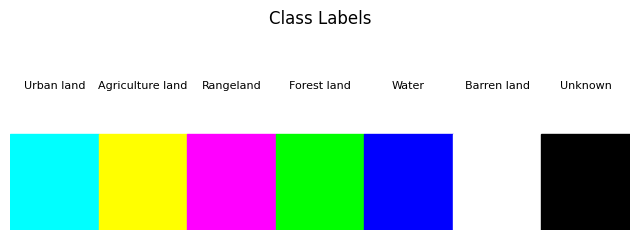

In [12]:
# Plot colors used and their corresponding labels

def create_custom_colormap():
    class_to_color = {
        0: [0, 255, 255],    # Urban land
        1: [255, 255, 0],    # Agriculture land
        2: [255, 0, 255],    # Rangeland
        3: [0, 255, 0],      # Forest land
        4: [0, 0, 255],      # Water
        5: [255, 255, 255],  # Barren land
        6: [0, 0, 0]         # Unknown
    }
    colormap = np.array([class_to_color[i] for i in range(len(class_to_color))], dtype=np.uint8)
    return colormap

# Class labels
class_labels = [
    "Urban land",
    "Agriculture land",
    "Rangeland",
    "Forest land",
    "Water",
    "Barren land",
    "Unknown"
]

fig, ax = plt.subplots(figsize=(8, 2.5))
colormap = create_custom_colormap()
colormap_normalized = colormap / 255.0  # Normalize colors to 0-1 for matplotlib
for idx, color in enumerate(colormap_normalized):
    ax.text(idx + 0.5, 1.5, class_labels[idx], color='black', ha='center', va='center', fontsize=8)
    ax.add_patch(plt.Rectangle((idx, 0), 1, 1, color=color))

ax.set_xlim(0, len(colormap))
ax.set_ylim(0, 2)
ax.axis('off')
ax.set_title("Class Labels", fontsize=12, pad=10)
plt.show()

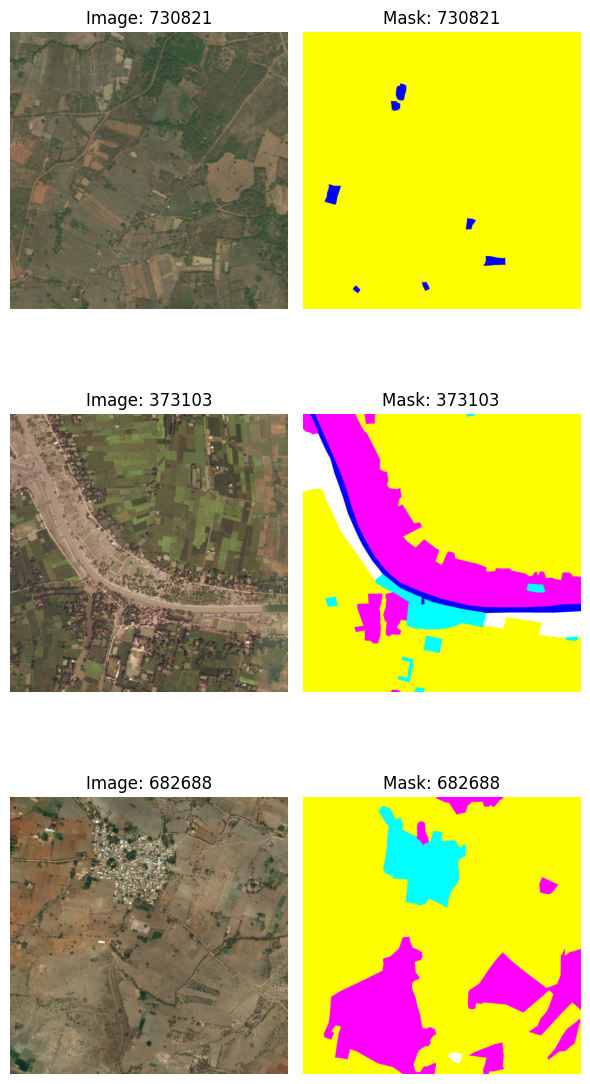

In [14]:
# Show random images and their masks

n_images = 3

# Get the list of image filenames (without extension) in the training images directory
image_filenames = [file.split('_sat')[0] for file in os.listdir(sat_directory) if '_sat' in file]

# Randomly select n image filenames
selected_filenames = random.sample(image_filenames, n_images)

# Plot images and their corresponding masks
fig, axs = plt.subplots(3, 2, figsize=(6, 12))

for i, filename in enumerate(selected_filenames):
    # Construct the full file path for the image and mask
    image_path = os.path.join(sat_directory, f"{filename}_sat.jpg")
    mask_path = os.path.join(mask_directory, f"{filename}_mask.png")

    # Load the image and mask
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Plot the image
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"Image: {filename}")

    # Plot the mask
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f"Mask: {filename}")

plt.tight_layout()
plt.show()

## Pre-process images and masks

In [15]:
def split_images(filepath, dest_filepath, n_sub_images):
  """
  Function to split a larger image into multiple images

  Parameters:
    filepath - source filepath
    dest_filepath - destination filepath
    n_sub_images - number of images to cut

  Return:
    None
  """
  for img_file in os.listdir(filepath):
    try:
        # Attempt to open an image file
        image = plt.imread(filepath + '/' + img_file)
    except IOError as e:
        # Report error, and then skip to the next argument
        print ("Problem opening", img_file, ":", e)
        continue

    pixels = int(image.shape[0] / math.sqrt(n_sub_images))

    count = 0

    for r in range(0,image.shape[0],pixels):
      for c in range(0,image.shape[1],pixels):

        # filename = img_file.split('.')[0]
        # filename_pre = filename.split('_')[0]
        # filename_cat = filename.split('_')[1]
        # extension = img_file.split('.')[1]

        base_filename, extension = os.path.splitext(img_file)
        parts = base_filename.split('_')
        new_filename = f"{parts[0]}_{count}_{parts[1]}{extension}"
        new_image_path = os.path.join(dest_filepath, new_filename)

        # Save new image file
        plt.imsave(new_image_path, image[r:r+pixels, c:c+pixels, :])
        count += 1

        # # Save new file type
        # plt.imsave(dest_filepath + filename_pre + '_{}_'.format(count) + filename_cat + '_' + extension, image[r:r+pixels, c:c+pixels,:])

        # count+=1

    os.remove(filepath + '/' + img_file)
  print('Images of: {}x{}'.format(pixels, pixels))

In [16]:
# Toggle True/False to enable split

run_split_images = True

# Set n for splits

n_splits = 4

if run_split_images:
  # Images
  split_images('data/images/', 'data/images/', n_splits)
  # Masks
  split_images('data/masks/', 'data/masks/', n_splits)

Images of: 1224x1224
Images of: 1224x1224


In [17]:
print(f'There are {len(os.listdir(sat_directory))} images after splitting.')
print(f'There are {len(os.listdir(mask_directory))} masks after splitting.')

There are 3212 images after splitting.
There are 3212 masks after splitting.


In [18]:
IMAGE_SIZE = 512
BATCH_SIZE = 16
NUM_CLASSES = 7
DATA_DIR = "data"

# Load all satellite images and mask images
all_sat_images = sorted(glob(os.path.join(DATA_DIR, "images/*_sat.jpg")))
all_mask_images = sorted(glob(os.path.join(DATA_DIR, "masks/*_mask.png")))

total_images = len(all_sat_images)

# Define the split percentages (80:10:10)
train_split = 0.8
val_split = 0.1

# Calculate split indices
train_index = int(total_images * train_split)
val_index = int(total_images * (train_split + val_split))  # End of validation set

# Splitting the dataset into training, validation, and testing
train_images = all_sat_images[:train_index]
train_masks = all_mask_images[:train_index]

val_images = all_sat_images[train_index:val_index]
val_masks = all_mask_images[train_index:val_index]

test_images = all_sat_images[val_index:]
test_masks = all_mask_images[val_index:]

In [19]:
def rgb_to_categorical(mask):
    """
    Function to define color-to-class mapping
    """
    color_to_class = {
        (0, 255, 255): 0,    # Urban land
        (255, 255, 0): 1,    # Agriculture land
        (255, 0, 255): 2,    # Rangeland
        (0, 255, 0): 3,      # Forest land
        (0, 0, 255): 4,      # Water
        (255, 255, 255): 5,  # Barren land
        (0, 0, 0): 6         # Unknown
    }
    labels = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
    for rgb, class_id in color_to_class.items():
        labels[(mask[:, :, 0] == rgb[0]) & (mask[:, :, 1] == rgb[1]) & (mask[:, :, 2] == rgb[2])] = class_id
    return labels

def augment(image, mask):
    # Randomly choose a number of 90-degree rotations
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image_rotated = tf.image.rot90(image, k)
    mask_rotated = tf.image.rot90(mask, k)
    return image_rotated, mask_rotated

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], method='nearest')
        image = tf.numpy_function(rgb_to_categorical, [image], tf.int32)
        image = tf.expand_dims(image, axis=-1)
        image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE], method='bilinear')
    return image

def load_data(image_path, mask_path, apply_augmentation=False):
    image = read_image(image_path)
    mask = read_image(mask_path, mask=True)
    if apply_augmentation:
        image, mask = augment(image, mask)
    return image, mask

def data_generator(image_list, mask_list, apply_augmentation=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(lambda img, msk: load_data(img, msk, apply_augmentation), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset = data_generator(train_images, train_masks, apply_augmentation=True)
val_dataset = data_generator(val_images, val_masks)
test_dataset = data_generator(test_images, test_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None))>
Test Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None))>


In [20]:
# Calculate the distribution of classes in the training set

def calculate_label_distribution_and_proportion(mask_paths):
    label_counts = defaultdict(int)
    total_count = 0

    for mask_path in mask_paths:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=3)
        mask = tf.image.resize(mask, [IMAGE_SIZE, IMAGE_SIZE], method='nearest')
        mask = rgb_to_categorical(mask.numpy())
        unique, counts = np.unique(mask, return_counts=True)
        for label, count in zip(unique, counts):
            label_counts[label] += count
            total_count += count

    # Calculate proportions
    label_proportions = {label: (count / total_count) * 100 for label, count in label_counts.items()}  # as percentage
    return label_proportions

# Calculate label proportions
label_proportions = calculate_label_distribution_and_proportion(train_masks)

# Label names for better readability
label_names = {
    0: "Urban land",
    1: "Agriculture land",
    2: "Rangeland",
    3: "Forest land",
    4: "Water",
    5: "Barren land",
    6: "Unknown"
}

# Convert to DataFrame for better visualization
df = pd.DataFrame(list(label_proportions.items()), columns=['Label', 'Proportion'])
df['Label Name'] = df['Label'].map(label_names)  # Map label numbers to names
df['Proportion'] = df['Proportion'].apply(lambda x: f"{x:.2f}%")  # Format as percentage
df = df[['Label', 'Label Name', 'Proportion']]  # Reorder columns
df.sort_values('Label', inplace=True)  # Sort by label

# Display the DataFrame
df

,Label,Label Name,Proportion
4,0,Urban land,10.95%
0,1,Agriculture land,58.22%
1,2,Rangeland,8.53%
6,3,Forest land,10.11%
3,4,Water,3.30%
5,5,Barren land,8.84%
2,6,Unknown,0.06%


## Initialise DeepLabV3+ model

In [21]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return ops.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [22]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    preprocessed = keras.applications.resnet50.preprocess_input(model_input)
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 512, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 512, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 512, 512)       │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 512, 512, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 518, 518, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 256, 256, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 256, 256, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 256, 256, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 258, 258, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 128, 128, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 128, 128, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 128, 128, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 128, 128, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 128, 128, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,853,895 (45.22 MB)

 Trainable params: 11,821,159 (45.09 MB)

 Non-trainable params: 32,736 (127.88 KB)

In [23]:
# Inspect features and labels before training

for data_batch, labels_batch in train_dataset:
  print("Data batch shape:", data_batch.shape)
  print("Labels batch shape:", labels_batch.shape)
  break

Data batch shape: (16, 512, 512, 3)
Labels batch shape: (16, 512, 512, 1)


In [24]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=loss,
    metrics=["accuracy"],
)

### Train the model

In [25]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=30)


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 135s 262ms/step - accuracy: 0.5561 - loss: 1.3024 - val_accuracy: 0.3971 - val_loss: 213.8402
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 234ms/step - accuracy: 0.6619 - loss: 0.9795 - val_accuracy: 0.5994 - val_loss: 2.6887
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.6954 - loss: 0.8815 - val_accuracy: 0.7744 - val_loss: 0.7046
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.7137 - loss: 0.8194 - val_accuracy: 0.7329 - val_loss: 0.8635
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.7211 - loss: 0.7903 - val_accuracy: 0.6353 - val_loss: 1.2211
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.7341 - loss: 0.7486 - val_accuracy: 0.7113 - val_loss: 1.7733
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 233ms/step - accuracy: 0.7548 - loss: 0.7005 - val_accuracy: 0.6314 - val_loss: 1.0632
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 38s 233ms/step - accuracy: 0.7540 - loss

## Plot training and validation accuracy and loss

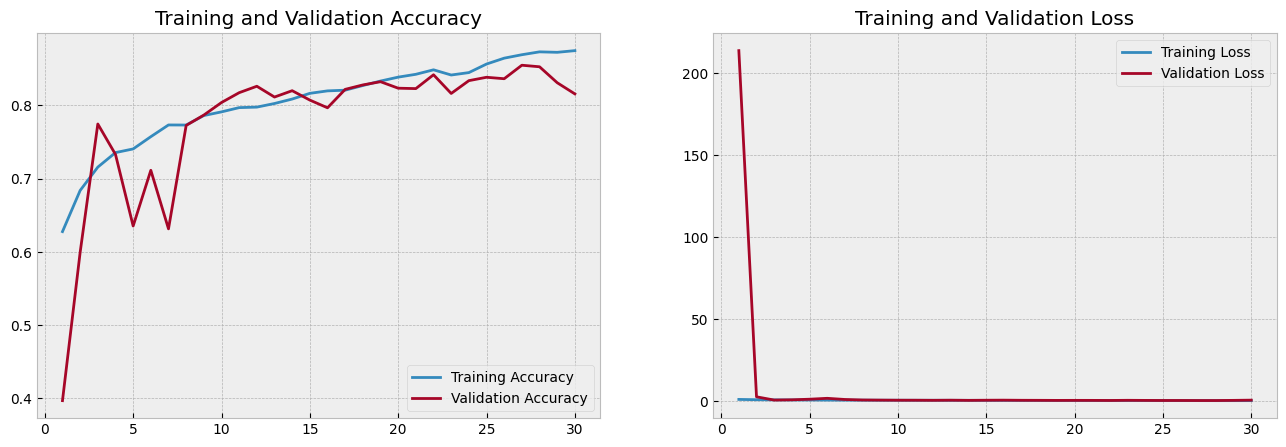

In [32]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]


epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(16, 5))
plt.style.use("bmh")
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate model on test data

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f" Model Test accuracy: {test_acc:.3f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7614 - loss: 0.9054
 Model Test accuracy: 0.778


Visualise results

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


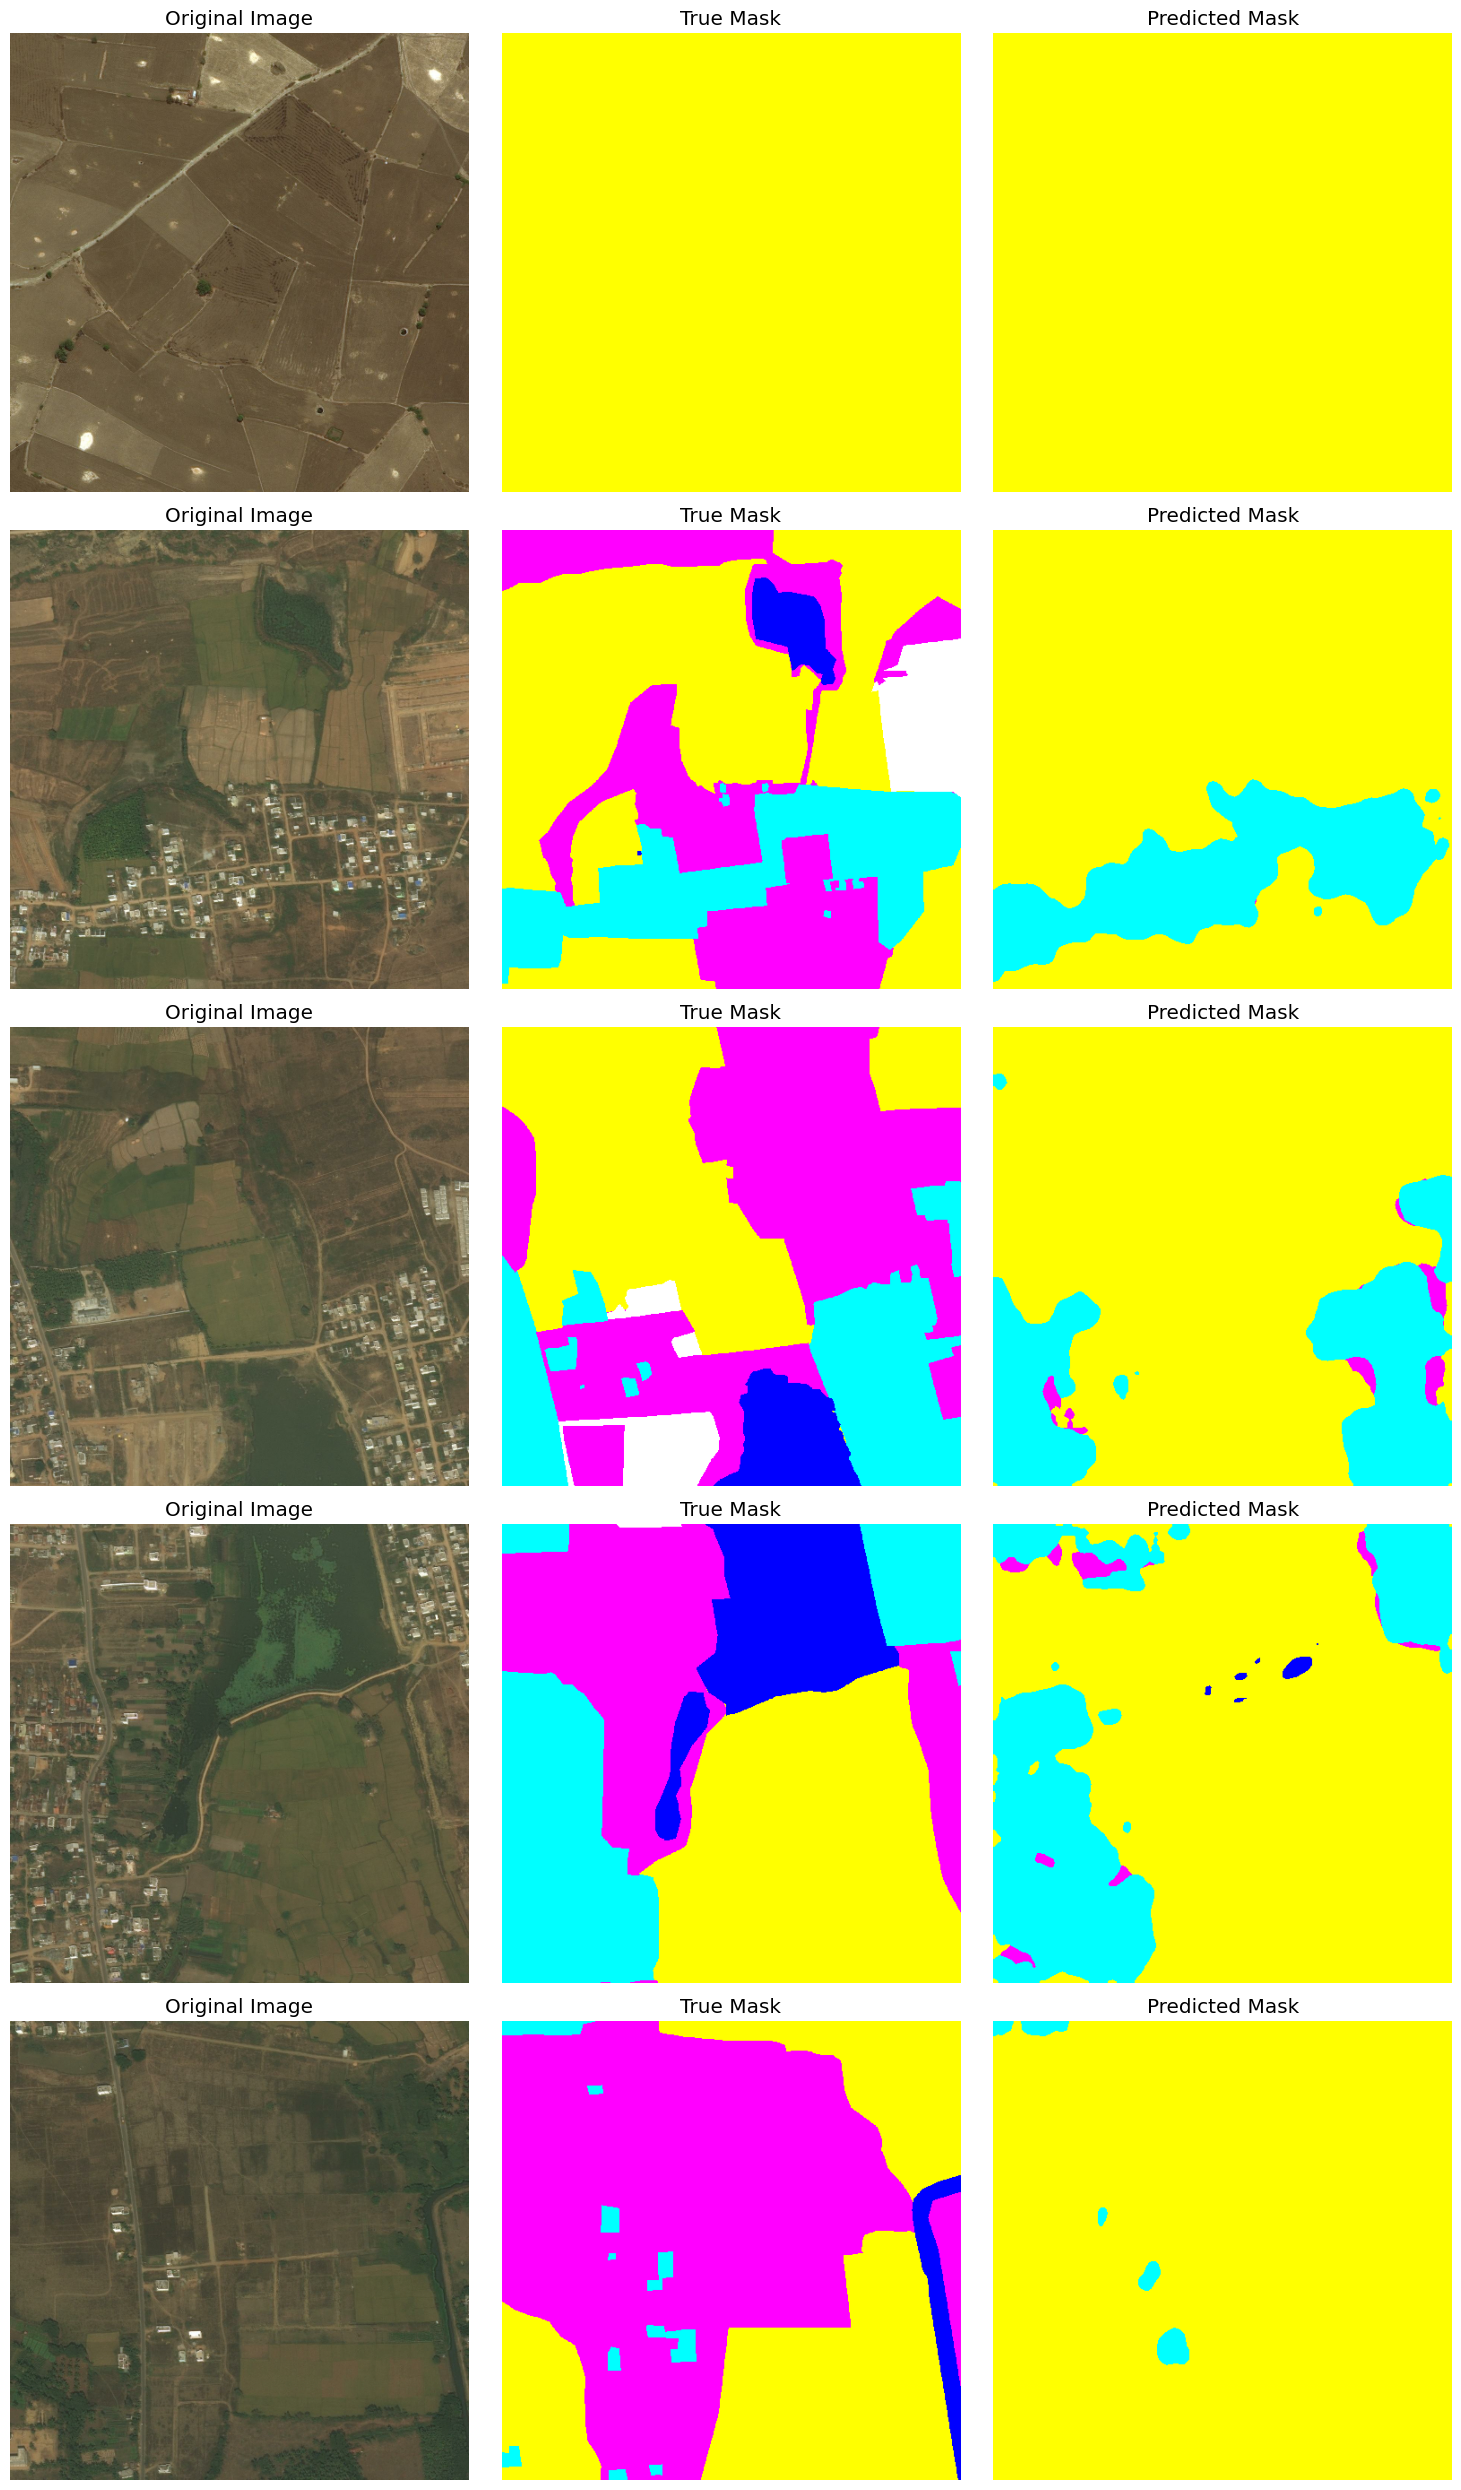

In [30]:
# Function to convert categorical mask to RGB using the colormap
def mask_to_color(mask, colormap):
    # Expand the last dimension to make it compatible with the colormap indexing
    color_mask = np.take(colormap, mask, axis=0)
    return color_mask

# Function to plot the images
def plot_images_with_masks(dataset, model, colormap, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))

    # Iterate through the dataset
    for i, (images, true_masks) in enumerate(dataset.unbatch().batch(2).take(num_samples)):
        # Predict the masks
        predicted_masks = model.predict(images)
        predicted_masks = np.argmax(predicted_masks, axis=-1)

        # Prepare images and masks for display
        image = images.numpy()[0]  # First image in the batch
        true_mask = true_masks.numpy()[0, :, :, 0]  # First true mask in the batch
        predicted_mask = predicted_masks[0]  # First predicted mask in the batch

        true_mask_rgb = mask_to_color(true_mask, colormap)
        predicted_mask_rgb = mask_to_color(predicted_mask, colormap)

        # Normalize image for display if necessary
        image = image / 255.0 if np.max(image) > 1.0 else image

        # Create subplots for each sample
        ax1 = plt.subplot(num_samples, 3, i * 3 + 1)
        ax1.imshow(image)
        ax1.title.set_text('Original Image')
        ax1.axis('off')

        ax2 = plt.subplot(num_samples, 3, i * 3 + 2)
        ax2.imshow(true_mask_rgb)
        ax2.title.set_text('True Mask')
        ax2.axis('off')

        ax3 = plt.subplot(num_samples, 3, i * 3 + 3)
        ax3.imshow(predicted_mask_rgb)
        ax3.title.set_text('Predicted Mask')
        ax3.axis('off')

    plt.tight_layout()
    plt.show()

colormap = create_custom_colormap()

# Visualize the images
plot_images_with_masks(test_dataset, model, colormap)
